In [1]:
import cv2
import numpy as np
from PIL import Image
import os
import glob

## 1) Création du dataset

Réglage de google drive pour collab :

In [2]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


In [3]:
# On récupère la data depuis un zip que l'on a déposé à la racine de notre drive
zip_path = "/content/gdrive/My Drive/data_seg.zip"

!cp "{zip_path}" .

!unzip -q data_seg.zip

### Conversion .tiff vers .png

In [4]:
from PIL import Image
import os

def tif_to_png (chemin_input, chemin_output):
    """
    Cette méthode convertit des tifs en png, il faut un dossier input et un dossier output
    et les noms des fichiers à convertir doivent être du type i.tif avec i commençant à 0.
    Dès qu'un indice n'est pas trouvé, la conversion s'arrête là.
    """
    
    # Vérification que le dossier d'output existe, sinon il est créé :
    if not os.path.exists(chemin_output):
        os.makedirs(chemin_output)
    
    i = 0
    termine = False
    while termine == False:
        try :
            im = Image.open(f'{chemin_input}/{i}.tif')
            im.save(f'{chemin_output}/{i}.png')

            i += 1
        except FileNotFoundError:
            termine = True
            print(i, "fichiers ont été convertis.")

Création des png pour le train :

In [5]:
tif_to_png("./data_seg/train/", "./data_seg/train/")

30 fichiers ont été convertis.


Création des png pour le test :

In [6]:
# Les données de test sont inutiles faute de labels, il faut créer les nôtres.
# tif_to_png("./data_seg/test/", "./data_seg/test/")

Création des png pour les labels :

In [7]:
tif_to_png("./data_seg/label", "./data_seg/label/")

30 fichiers ont été convertis.


### Import des images

## 2) Data Augmentation

Nous allons procéder à de la data augmentation pour simuler un dataset plus conséquent et permettre un meilleur apprentissage. Pour ce faire, on utilise OpenCV.

**Rotation :**

In [8]:
def DA_rotation (chemin_input, chemin_output):
    """Méthode qui crée un dossier de fichiers rotatés dans le répertoire courant."""
    folder_len = len(chemin_input)

    os.mkdir(chemin_output)

    for img in glob.glob(chemin_input+"*.png"):
        image = cv2.imread(img)
        h, w = image.shape[:2]
        matrice_rot = cv2.getRotationMatrix2D((w/2, h/2), 45, .5)
        rotated_img = cv2.warpAffine(image, matrice_rot, (w,h))
        cv2.imwrite(chemin_output+img[folder_len:],rotated_img)

In [9]:
DA_rotation(chemin_input = "./data_seg/train/", chemin_output = "./data_seg/Rotation/")

In [10]:
DA_rotation(chemin_input = "./data_seg/label/", chemin_output = "./data_seg/RotationLabel/")

**Luminosité + :**

In [11]:
def DA_bright_up (chemin_input, chemin_output):
    """Méthode qui crée un dossier de fichiers plus clairs dans le répertoire courant."""
    folder_len = len(chemin_input)

    os.mkdir(chemin_output)

    for img in glob.glob(chemin_input+"*.png"):
        image = cv2.imread(img)
        bright = np.ones(image.shape, dtype="uint8")*70
        brighter_img = cv2.add(image, bright) # adding bright to image
        cv2.imwrite(chemin_output+img[folder_len:],brighter_img)

In [12]:
DA_bright_up(chemin_input = "./data_seg/train/", chemin_output = "./data_seg/BrightUp/")

**Luminosité - :**

In [13]:
def DA_bright_down (chemin_input, chemin_output):
    """Méthode qui crée un dossier de fichiers plus clairs dans le répertoire courant."""
    folder_len = len(chemin_input)

    os.mkdir(chemin_output)

    for img in glob.glob(chemin_input+"*.png"):
        image = cv2.imread(img)
        dark = np.ones(image.shape, dtype="uint8")*70
        darker_img = cv2.subtract(image, dark)
        cv2.imwrite(chemin_output+img[folder_len:],darker_img)

In [14]:
DA_bright_down(chemin_input = "./data_seg/train/", chemin_output = "./data_seg/BrightDown/")

**Sharpening (netteté) :**

Sharpening est l'inverse de blurring (netteté vs flou).

In [15]:
def DA_sharpen (chemin_input, chemin_output):
    """Méthode qui crée un dossier de fichiers plus nets dans le répertoire courant."""
    folder_len = len(chemin_input)

    os.mkdir(chemin_output)

    for img in glob.glob(chemin_input+"*.png"):
        image = cv2.imread(img)
        sharpening = np.array([[-1,-1,-1],
                               [-1,10,-1],
                               [-1,-1,-1] ])
        sharpened_img = cv2.filter2D(image,-1,sharpening)
        cv2.imwrite(chemin_output+img[folder_len:],sharpened_img)

In [16]:
DA_sharpen(chemin_input = "./data_seg/train/", chemin_output = "./data_seg/Sharpen/")

In [17]:
def DA_flip (chemin_input, chemin_output):
    """Méthode qui crée un dossier de fichiers inversés dans le répertoire courant."""
    folder_len = len(chemin_input)

    os.mkdir(chemin_output)

    for img in glob.glob(chemin_input+"*.png"):
        image = cv2.imread(img)
        flipped = cv2.flip(image,3)
        cv2.imwrite(chemin_output+img[folder_len:],flipped)

In [18]:
DA_flip(chemin_input = "./data_seg/label/", chemin_output = "./data_seg/FlippedLabel/")

In [19]:
DA_flip(chemin_input = "./data_seg/train/", chemin_output = "./data_seg/Flipped/")

In [20]:
def DA_blur (chemin_input, chemin_output):
    """Méthode qui crée un dossier de fichiers plus flous dans le répertoire courant."""
    folder_len = len(chemin_input)
    
    os.mkdir(chemin_output)

    for img in glob.glob(chemin_input+"*.png"):
        image = cv2.imread(img)
        blurred_img = cv2.blur(image,(5,5))
        cv2.imwrite(chemin_output+img[folder_len:],blurred_img)

In [21]:
DA_blur(chemin_input = "./data_seg/train/", chemin_output = "./data_seg/Blur/")

## 3) Modèle de segmentation

Toute cette partie a été conduite sur Google Collab pour tirer parti du GPU.

### Création du train/test set

In [22]:
train_normal = [cv2.imread(file, 0) for file in glob.glob("./data_seg/train/*.png")]
train_bright = [cv2.imread(file, 0) for file in glob.glob("./data_seg/BrightUp/*.png")]
train_dark = [cv2.imread(file, 0) for file in glob.glob("./data_seg/BrightDown/*.png")]
train_sharp = [cv2.imread(file, 0) for file in glob.glob("./data_seg/Sharpen/*.png")]
train_blur = [cv2.imread(file, 0) for file in glob.glob("./data_seg/Blur/*.png")]
train_rotation = [cv2.imread(file, 0) for file in glob.glob("./data_seg/Rotation/*.png")]
train_flip = [cv2.imread(file, 0) for file in glob.glob("./data_seg/Flipped/*.png")]

# Ajoutons toutes ces versions des images de train dans un grand x_train consolidé :
x_train = (train_normal + train_bright + train_dark + train_sharp + train_blur + train_rotation + train_flip )
x_train = np.array(x_train).astype(np.float32)

# x_test doit être fait à la main car dans le dataset les images test n'ont pas leur label associé.
# x_test = np.array([cv2.imread(file, 0) for file in glob.glob("./data_seg/test/*.png")]).astype(np.float32)

labels = [cv2.imread(file, 0) for file in glob.glob("./data_seg/label/*.png")]
# La nature un peu particulière de la data-augmentation flip et rotation nécessite de recréer des labels data-augmentés de la même façon :
labelsRotated = [cv2.imread(file, 0) for file in glob.glob("./data_seg/RotationLabel/*.png")]
labelsFlipped = [cv2.imread(file, 0) for file in glob.glob("./data_seg/FlippedLabel/*.png")]

# On remplit nos targets avec les images de labels normaux plus les labels tournés et renversés en miroir :
y_train = labels + labels + labels + labels + labels + labelsRotated + labelsFlipped
y_train = np.array(y_train).astype(np.float32)

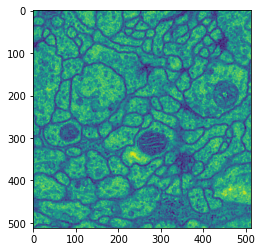

In [23]:
from matplotlib import pyplot as plt
plt.imshow(x_train[0])

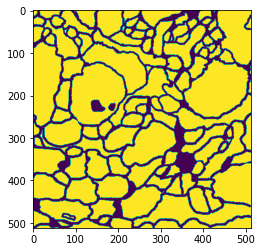

In [24]:
plt.imshow(y_train[0])

On vérifie que les longueurs de nos variables sont correctes (et égales) :

In [25]:
len(x_train)

210

In [26]:
len(y_train)

210

Maintenant que l'on dispose de 210 images au lieu de 30, on va devoir créer un x_test nous-même à partir de notre x_train data-augmenté. Nous allons séparer ce dernier en jeux d'apprentissage et de test à l'aide de sklearn.

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
x_train2, x_test, y_train2, y_test = train_test_split(x_train, y_train, test_size=0.2, shuffle = True)

In [29]:
x_train2.shape

(168, 512, 512)

In [30]:
y_train2.shape

(168, 512, 512)

In [31]:
x_test.shape

(42, 512, 512)

In [32]:
y_test.shape

(42, 512, 512)

Prétraitement des données :

On va passer toutes nos valeurs en type np.float32.

In [33]:
x_train3 = np.array(x_train2).astype(np.float32)
y_train3 = np.array(y_train2).astype(np.float32)

In [34]:
# Prétraitement initialement utilisé (pour legacy) :

# mean = np.mean(x_train3)  # on calcule la moyenne des tenseurs pour pouvoir centrer la donnée
# std = np.std(x_train3)  # on calcule l'écart-type pour la normalisation

# # Prétraitement, la normalisation du jeu d'entraînement :
# x_train_p = x_train3.copy()
# x_train_p /= std
# x_train_p = x_train_p.astype('float32')
# x_train_p -= mean # on enlève aux tenseurs la moyenne
# x_train_p = preprocess(x_train_p) # on reshape pour le modèle


# y_train_p = y_train3 / std

Pour le pré-traitement des données, on se contente d'une division de chaque valeur de pixel par 255. afin d'avoir une valeur comprise entre 0 et 1 pour chaque pixel. On étend également les dimensions de 1 pour avoir le canal (images en noir et blanc).

In [35]:
x_test.shape

(42, 512, 512)

In [36]:
x_train_p = x_train3.copy()
x_train_p /= 255.
x_train_p = np.expand_dims(x_train_p, -1)

y_train_p = y_train3.copy()
y_train_p /= 255.
y_train_p = np.expand_dims(y_train_p, -1)

x_test_p = x_test.copy()
x_test_p /= 255.
x_test_p = np.expand_dims(x_test_p, -1)

y_test_p = y_test.copy()
y_test_p /= 255.
y_test_p = np.expand_dims(y_test_p, -1)


### Création du modèle

Réseau de neurone à convolution spécialement développé pour la segmentation d'images biomédicales.

C'est un réseau exclusivement convolutionnel (pas de couche Dense). En voici un exemple tiré d'internet : 

![image.png](attachment:image.png)

Comme métrique pour attester de l'efficacité de notre modèle à résoudre le problème de segmentation considéré, nous allons utiliser le coefficient de Dice.
![image.png](attachment:image.png)
Ce coefficient mesurera la similarité entre nos prédictions et nos label.

In [37]:
from __future__ import print_function

import os

from skimage.transform import resize
from skimage.io import imsave
from skimage import io
from skimage.exposure import rescale_intensity

import numpy as np

from skimage.segmentation import mark_boundaries

# On installe les parties de keras dont on a besoin via tensorfow pour ne pas avoir à pip install keras :
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K # Voir cellule ci-dessous.
from tensorflow.keras.callbacks import History
#from data import load_train_data, load_test_data

Petite explication sur le `from tensorflow.keras import backend as K` :

En fait, Keras gère les modèles de deep learning en haut niveau, la librairie n'est pas adaptée en tant que telle à manier les tenseurs, les convolutions, etc. Pour ce faire, Keras se repose sur une librairie de manipulation de tenseurs intégrée de façon dynamique et modulable. Plusieurs moteurs backend peuvent ainsi être branchés sur Keras sans problème via l'API `backend` de keras (par exemple TensorFlow que l'on a vu, ou encore Theano). On appelle notre backend K.

In [38]:
K.set_image_data_format('channels_last')  # Ici on choisit le format conventionnel de notre data.
# "channel_last" veut dire que l'int de fin de la feature correspond au canal (ici 1 car une seule couleur).

img_rows = 512 # nombre de lignes de nos images
img_cols = 512 # nombre de colonnes de nos images

smooth = 1. # Coeff de lissage pour éviter les 

Création de notre métrique :

In [39]:
def dice_coef(y_true, y_pred):
    # Ici on reproduit la formule montrée plus haut pour le coeff Dice.
    y_true_f = K.flatten(y_true) # Les arrays à comparer doivent être écrasés donc on utilise flatten()
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    coeff_dice = (2. * intersection + smooth)/(K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return coeff_dice

Création de la fonction coût (loss) qu'utilisera notre modèle :

In [40]:
def dice_coef_loss(y_true, y_pred):
    # La fonction coût à minimiser est l'opposé du coefficient Dice.
    # Dit autrement, on veut un Dice le plus haut possible (1).
    return 1 - dice_coef(y_true, y_pred)

Création du modèle Unet qui prend en input les images correctement formatées avec le channel en last. L'output est envoyé par la dernière couche (conv10).

On voit bien l'architecture en U avec d'abord des convolutions simples qui réduisent la taille de l'image puis on remonte vers l'output avec un upsampling produit par les couches de (dé-)convolution transpose.

In [41]:
def get_unet():

    inputs = Input((img_rows, img_cols, 1))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    # Tentative de Dropout pour forcer l'apprentissage de features généralisables :
    # conv5 = Dropout(0.5)(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=5e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [43]:
# On génère un modèle U-net :
model = get_unet()

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

In [45]:
# Pour les poids, on ne gardera que le meilleur checkpoint au regard de la fonction coût en validation (la plus basse, bien sûr)
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

# En deuxième callback, on s'ajoute également un ReduceLROnPlateau afin de réduire le pas d'apprentissage quand la val_loss stagne
# pour continuer à apprendre des features généralisables le plus longtemps possible.
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=5e-5,
                              verbose=1)

# On réalise l'entraînement du modèle
history = model.fit(x_train_p,
                    y_train_p,
                    batch_size=10,
                    epochs=70,
                    verbose=1,
                    #shuffle=True,
                    validation_split=0.2,
                    callbacks=[model_checkpoint, reduce_lr])

Epoch 1/70
14/14 [==============================] - 61s 1s/step - loss: 0.2647 - dice_coef: 0.7355 - val_loss: 0.9953 - val_dice_coef: 0.0047
Epoch 2/70
14/14 [==============================] - 11s 775ms/step - loss: 0.1317 - dice_coef: 0.8682 - val_loss: 0.9994 - val_dice_coef: 6.4573e-04
Epoch 3/70
14/14 [==============================] - 11s 779ms/step - loss: 0.1317 - dice_coef: 0.8680 - val_loss: 0.9612 - val_dice_coef: 0.0389
Epoch 4/70
14/14 [==============================] - 11s 784ms/step - loss: 0.1166 - dice_coef: 0.8835 - val_loss: 0.9302 - val_dice_coef: 0.0698
Epoch 5/70
14/14 [==============================] - 11s 790ms/step - loss: 0.1106 - dice_coef: 0.8895 - val_loss: 0.1618 - val_dice_coef: 0.8416
Epoch 6/70
14/14 [==============================] - 11s 792ms/step - loss: 0.0979 - dice_coef: 0.9021 - val_loss: 0.1482 - val_dice_coef: 0.8553
Epoch 7/70
14/14 [==============================] - 11s 795ms/step - loss: 0.1004 - dice_coef: 0.8995 - val_loss: 0.1506 - val_di

Notre modèle est entraîné, tentons maintenant de réaliser une prédiction sur notre jeu de test.

In [46]:
# on charge le fichier de poids de modèle créé lors du checkpoint :
model.load_weights('weights.h5') 

# On fait la prédiction sur test avec ce modèle:
y_test_pred = model.predict(x_test_p, verbose=1)

2/2 [==============================] - 22s 283ms/step


On remarque dans l'output de la cellule précédente que l'apprentissage s'est bien passé mais qu'une erreur de mémoire survient lors de la prédiction. Nous allons reprendre le modèle tel quel mais appliquer un batch_size suffisamment petit pour éviter l'erreur lors de la prédiction.

In [47]:
# On fait la prédiction sur test avec ce modèle:
y_test_pred = model.predict(x_test_p, verbose=1, batch_size=5)

9/9 [==============================] - 8s 428ms/step


La prédiction s'est mieux déroulée cette fois. On peut calculer notre métrique de coefficient de Dice pour la prédiction de test par rapport aux labels attendus.

In [48]:
# Le coefficient de dice est issu d'une fonction qu'on a créée qui renvoie un
# objet de type tensorflow.python.framework.ops.EagerTensor. Si on veut récupérer
# la valeur du métrique Dice en test, il suffit de récupérer uniquement la valeur :

# Coefficient de Dice en test :
dice_coef_test = dice_coef(y_test_p, y_test_pred)
# Sa valeur !
dice_coef_test.numpy()

0.9551871

On a une précision en test de plus de 95%, ce qui est assez correct. On peut s'amuser à visualiser ce que ça donne concrètement à l'aide de pyplot sur une instance :

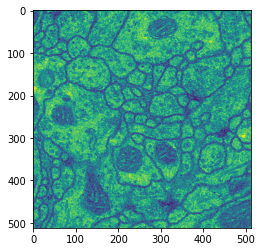

In [54]:
plt.imshow(x_test_p[0].squeeze())

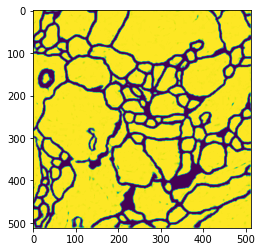

In [55]:
plt.imshow(y_test_pred[0].squeeze())

## 4) Visualisation de l'apprentissage                                             

Nous allons afficher la courbe de la fonction loss et la courbe de l'accuracy du modèle (entraînement et validation). Comme on a enregistré notre fit dans une variable history, nous avons directement accès à l'évolution des métriques dans le temps lors de l'apprentissage. Il suffit de récupérer les bonnes clés de l'attribut history de notre variable history.

In [73]:
history.history.keys()

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef', 'lr'])

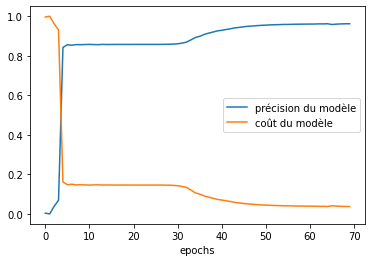

In [70]:
from matplotlib import pyplot as plt

plt.plot(history.history["val_dice_coef"],label="précision du modèle") # ici la est précision le coeff de Dice
plt.plot(history.history['val_loss'],label="coût du modèle")
plt.xlabel("epochs")
plt.legend()

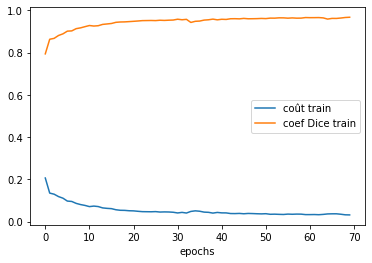

In [71]:
plt.plot(history.history['loss'],label="coût train")
plt.plot(history.history['dice_coef'],label="coef Dice train")
plt.xlabel("epochs")
plt.legend()